In [1]:
import uproot
import scipy
import numpy as np
import awkward as ak

import pandas as pd

import matplotlib as mpl
import matplotlib.pyplot as plt
%matplotlib inline
plt.rcParams['image.cmap'] = 'Purples'
plt.rcParams['figure.figsize'] = (9,7)
plt.rcParams['savefig.dpi'] = 200
plt.rc('figure', figsize=(9,7))
plt.rcParams['savefig.dpi']
plt.rcParams["lines.linewidth"] = 2

import mplhep as hep
plt.style.use(hep.style.ROOT)

from scipy.optimize import curve_fit
from scipy.stats import norm

In [2]:
f = uproot.open("/home/work/gem/testbeam/may2022/tracks/00000074_full.root")
f.keys()

['trackTree;1134', 'trackTree;1133']

In [3]:
t = f["trackTree"]
print(t.num_entries, "events")
t.show()

54271590 events
name                 | typename                 | interpretation                
---------------------+--------------------------+-------------------------------
orbitNumber          | int32_t                  | AsDtype('>i4')
bunchCounter         | int32_t                  | AsDtype('>i4')
eventCounter         | int32_t                  | AsDtype('>i4')
tracks_X_chi2        | std::vector<double>      | AsJagged(AsDtype('>f8'), he...
tracks_Y_chi2        | std::vector<double>      | AsJagged(AsDtype('>f8'), he...
tracks_X_slope       | std::vector<double>      | AsJagged(AsDtype('>f8'), he...
tracks_Y_slope       | std::vector<double>      | AsJagged(AsDtype('>f8'), he...
tracks_X_intercept   | std::vector<double>      | AsJagged(AsDtype('>f8'), he...
tracks_Y_intercept   | std::vector<double>      | AsJagged(AsDtype('>f8'), he...
tracks_X_covariance  | std::vector<double>      | AsJagged(AsDtype('>f8'), he...
tracks_Y_covariance  | std::vector<double>      | AsJagged(A

In [4]:
keys = t.keys()
events = t.arrays(
    [
        "rechitClusterCenter", "rechitClusterSize", "rechitChamber", "rechitEta", "rechitLocalX",
        "prophitChamber", "prophitGlobalX", "prophitGlobalY"
    ],
    #entry_stop = 1000000
)
print(len(events["rechitClusterCenter"]), "events")

print(events["rechitChamber"])
print(events["rechitClusterCenter"])
print(events["rechitLocalX"])
print(events["rechitClusterSize"])

54271590 events
[[4, 5, 6, 6, 6], [4, 5, 6, 6, 6, 6], ... 5, 5, 6, 6, 6, 6, 6], [4, 4, 5, 5, 6]]
[[276, 137, 67, 59, 137], [303, 299, 120, ... 74, 132], [301, 301, 223, 227, 299]]
[[126, -9.25, -16.9, 52.8, 68], [156, ... 92.5], [154, 154, -9.79, -74.5, -55.5]]
[[1, 2, 2, 2, 3], [3, 1, 1, 4, 1, 1], ... 1, 1, 2, 1, 1, 1, 1], [3, 1, 1, 2, 1]]


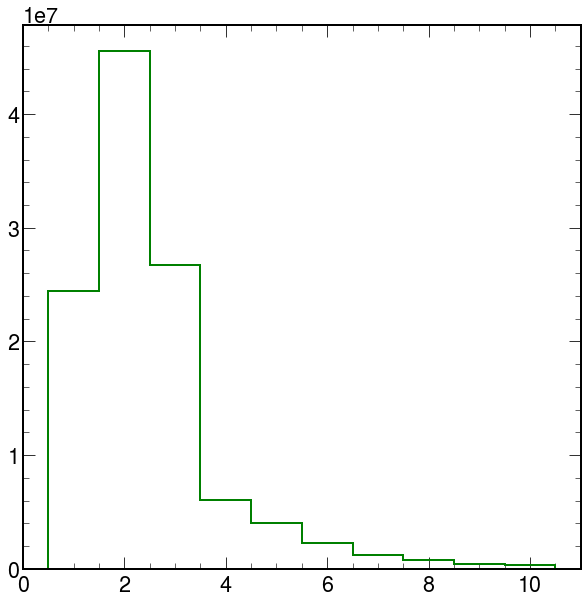

In [5]:
chamber = 4
eta = 6

_ = plt.hist(
    ak.flatten(events["rechitClusterSize"][events["rechitChamber"]==chamber]),
    bins=10, linewidth=2, color="green", histtype="step", range=(0.5,10.5)
)
#_ = plt.hist(prophits_y, bins=100, linewidth=2, color="red", histtype="step")

In [6]:
_ = plt.hist(
    ak.flatten(events["prophitGlobalY"][prophit_chamber==chamber]),
    bins=100, linewidth=2, color="green", histtype="step"
)
#_ = plt.hist(prophits_y, bins=100, linewidth=2, color="red", histtype="step")

NameError: name 'prophit_chamber' is not defined

[[1, 2, 2, 2, 3], [3, 1, 1, 4, 1, 1], ... 1, 1, 2, 1, 1, 1, 1], [3, 1, 1, 2, 1]]
[[276, 137, 67, 59, 137], [303, 299, 120, ... 74, 132], [301, 301, 223, 227, 299]]
[[276], [], [], [], [283], [300], [], [], ... [275], [287], [], [], [285], [276], []]
54271590
(128.5, 384.5) 256
[[276], [], [], [], [283], [300], [], [], ... [275], [287], [], [], [285], [276], []]


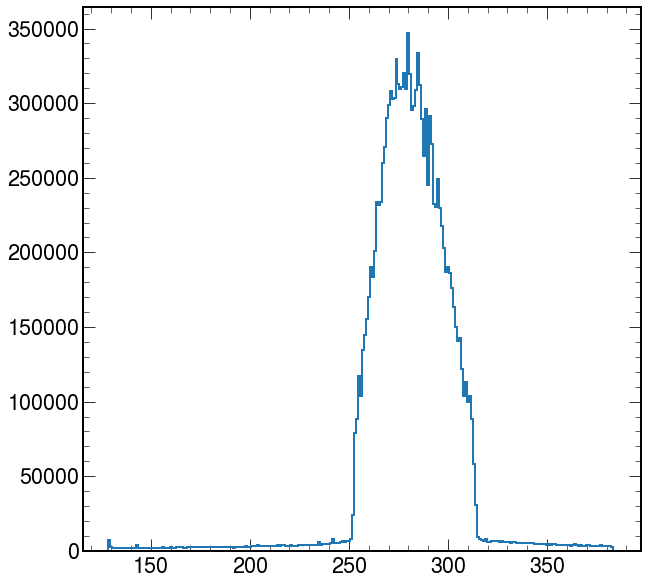

In [7]:
chamber = 4
eta = 6

prophit_chamber = events["prophitChamber"]
prophits_x = ak.flatten(events["prophitGlobalX"][prophit_chamber==chamber])
#prophits_y = ak.flatten(events["prophitGlobalY"][prophit_chamber==chamber])

rechit_chamber = events["rechitChamber"]
rechit_cluster_size = events["rechitClusterSize"]
rechit_eta = events["rechitEta"]

rechit_selection = (rechit_chamber==chamber)&(rechit_eta==eta)
rechit_selection = rechit_selection&(rechit_cluster_size>0)
strip_filter = (events["rechitClusterCenter"]>=0)&(events["rechitClusterCenter"]<=400)

print(events["rechitClusterSize"])
print(events["rechitClusterCenter"])
rechit_cluster_size = events["rechitClusterSize"][strip_filter][rechit_selection]
rechits_center = events["rechitClusterCenter"][strip_filter][rechit_selection]
#prophits_x = prophits_x[strip_filter]
print(rechits_center)

single_filter = ak.count(rechits_center, axis=1)<2
print(ak.count(single_filter))
rechits_center = rechits_center[single_filter]
rechit_cluster_size = rechit_cluster_size[single_filter]
prophits_x = prophits_x[single_filter]

rechit_range = (ak.min(rechits_center)-0.5, ak.max(rechits_center)+0.5)
rechit_bins = int(rechit_range[1]-rechit_range[0])
print(rechit_range, rechit_bins)
_ = plt.hist(
    ak.flatten(rechits_center),
    bins=rechit_bins, range=rechit_range,
    linewidth=2, histtype="step"
)
print(rechits_center)

(array([42527465.,        0.,        0.,        0.,        0.,        0.,
               0.,        0.,        0., 70265979.]),
 array([6. , 6.1, 6.2, 6.3, 6.4, 6.5, 6.6, 6.7, 6.8, 6.9, 7. ]),
 <BarContainer object of 10 artists>)

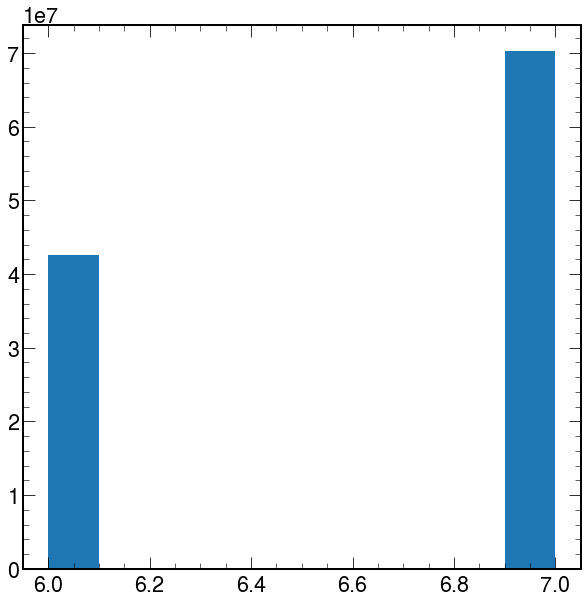

In [8]:
rechit_eta = events["rechitEta"][rechit_chamber==chamber]

plt.hist(ak.flatten(rechit_eta))

[[276], [], [], [], [283], [300], [], [], ... [275], [287], [], [], [285], [276], []] 14222377
[[-10.4], [], [], [], [-0.715], [23.1], ... [5.36], [], [], [2.31], [-10.6], []] 14222377


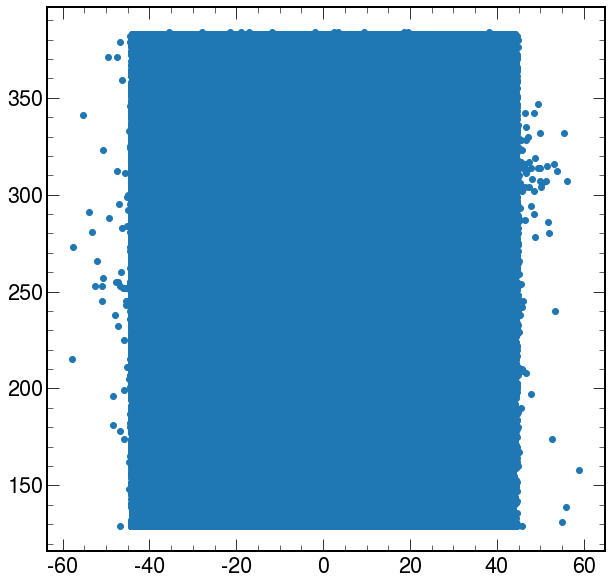

In [9]:
""" Quite useless because of the background, apart from debugging """

prophits_x_broad, _ = ak.broadcast_arrays(prophits_x, rechits_center)
_ = plt.scatter(
    ak.flatten(prophits_x_broad), ak.flatten(rechits_center),
)
print(rechits_center, ak.count(ak.flatten(rechits_center)))
print(prophits_x_broad, ak.count(ak.flatten(prophits_x_broad)))

[-10.4, 29.3, 23.6, 15.8, -0.715, 23.1, ... 5.36, -24.9, -5, 2.31, -10.6, 30.1]
[[276], [], [], [], [283], [300], [], [], ... [275], [287], [], [], [285], [276], []]
means [256. 257. 258. 259. 260. 262. 263. 264. 265. 266. 267. 268. 269. 270.
 272. 273. 274. 275. 276. 277. 278. 280. 281. 282. 283. 284. 285. 286.
 287. 288. 289. 291. 292. 293. 294. 295. 296. 297. 298. 299. 300. 302.
 303. 304. 305. 306. 307. 308. 309. 310.]
[  0.69390756 283.26      ]


Text(0, 1, 'Rechit strip')

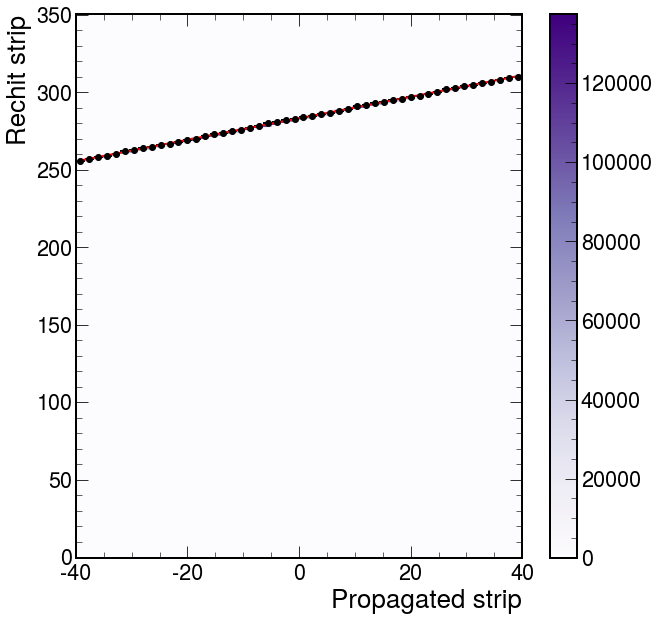

In [10]:
""" Perform calibration of propagated x to strip on detector """
print(prophits_x)
print(rechits_center)
prophits_x_broad, _ = ak.broadcast_arrays(prophits_x, rechits_center)

prophit_range = (-40,40)
strip_range = (0-0.5, 350+0.5)
strip_bins = int(strip_range[1]-strip_range[0]-1)

_ = plt.hist2d(
    ak.flatten(prophits_x_broad), ak.flatten(rechits_center),
    bins=(100, strip_bins), range=(prophit_range,strip_range),
    #norm=mpl.colors.LogNorm()
)
plt.colorbar()

""" Bin the propagated hits """
strip_means, prophit_edges, _ = scipy.stats.binned_statistic(
    ak.flatten(prophits_x_broad), ak.flatten(rechits_center),
    lambda x: scipy.stats.mode(x)[0][0], bins=50, range=prophit_range
)
print("means", strip_means)
prophit_centers = 0.5*(prophit_edges[1:]+prophit_edges[:-1])
prophit_errs = 0.5*(prophit_edges[1:]-prophit_edges[:-1])
_ = plt.errorbar(
    prophit_centers, strip_means, xerr=prophit_errs, fmt="ok"
)

linear = lambda x, A, B: A*x+B
p0 = [1, -100]
#popt, pcov = curve_fit(linear, ak.flatten(prophits_x_broad), ak.flatten(rechits_center), p0=p0)
popt, pcov = curve_fit(linear, prophit_centers, strip_means, p0=p0)
print(popt)
prophits_center = linear(prophits_x, *popt)

x = np.linspace(prophit_range[0], prophit_range[1], 100)
_ = plt.plot(
    x, linear(x, *popt), "-", color="red"
)
plt.xlabel("Propagated strip")
plt.ylabel("Rechit strip")

Text(0, 1, 'Propagated strip')

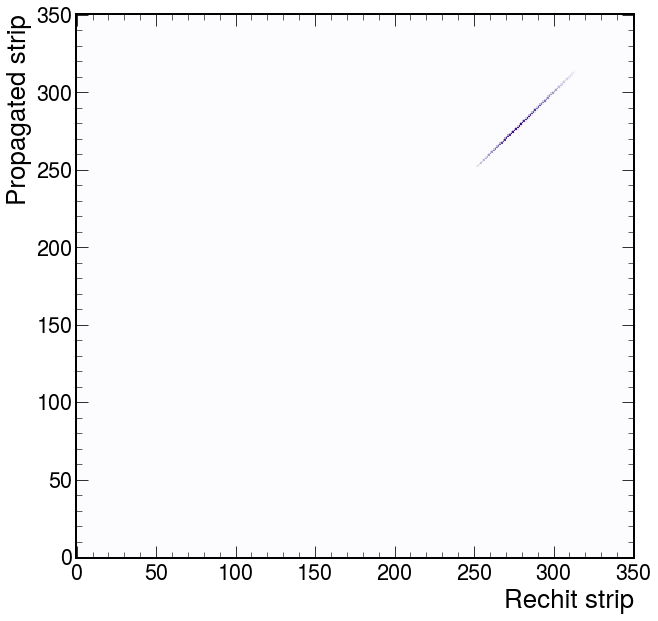

In [11]:
""" Check that the calibration went well """

prophits_center_broad, _ = ak.broadcast_arrays(prophits_center, rechits_center)

_ = plt.hist2d(
    ak.flatten(rechits_center), ak.flatten(prophits_center_broad),
    bins=(strip_bins, strip_bins), range=(strip_range, strip_range)
)
plt.xlabel("Rechit strip")
plt.ylabel("Propagated strip")

residuals [[-0.0111], [], [], [], [0.236], [0.69], ... [0.0228], [], [], [0.134], [0.0699], []]
[-0.0111, 0.236, 0.69, -0.25, 0.513, 0.325, ... 0.228, 0.595, 0.0228, 0.134, 0.0699]
RMS 0.6550522992619172
[ 1.24871229e+06  2.49722843e-01  4.60092873e-01  8.07839681e+05
 -3.82779309e-01  4.25773270e-01]
[2.55969277e+05 7.48040039e-02 2.34696992e-02 2.55753016e+05
 8.04055413e-02 2.29408126e-02]
sigma1 = 0.46 +- 0.02
mean = 0.25


'texgyreheros-regular.otf' can not be subsetted into a Type 3 font. The entire font will be embedded in the output.


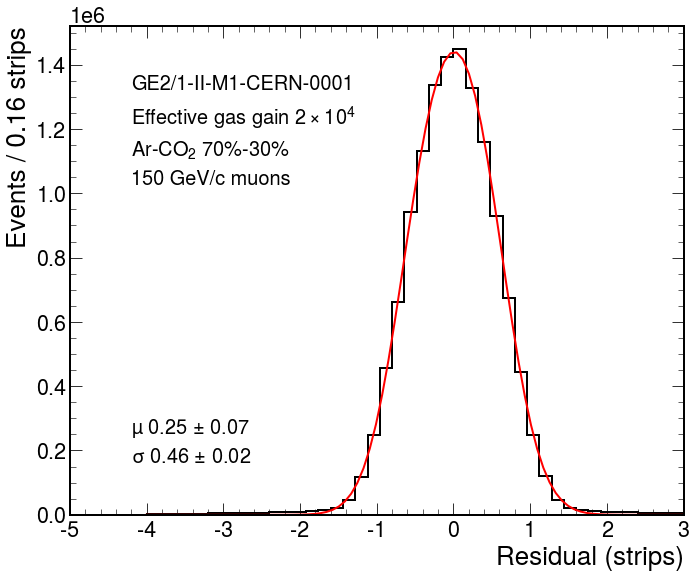

In [31]:
fig, ax = plt.subplots(figsize=(11,9))

residuals = rechits_center - prophits_center_broad

residual_filter = (rechits_center>0)&(rechits_center<400)
#residual_filter = (rechits_center>250)&(rechits_center<300)
#residual_filter = (residual_filter)&(rechit_cluster_size==cluster_size)
residuals = residuals[residual_filter]
print("residuals", residuals)

gauss = lambda x, A, mean, sigma: A*norm.pdf(x, mean, sigma)
gauss2 = lambda x, A1, mean1, sigma1, A2, mean2, sigma2: gauss(x, A1, mean1, sigma1) + gauss(x, A2, mean2, sigma2)

residuals_flat = ak.flatten(residuals)
residuals_min_filter = ak.argmin(abs(residuals), axis=1, keepdims=True)
residuals_flat = ak.flatten(residuals[residuals_min_filter])
residuals_flat = residuals_flat[~ak.is_none(residuals_flat)]
print(residuals_flat)
residual_values, residual_edges, _ = ax.hist(
    residuals_flat,
    bins=50, range=(-4, 4),
    color="black", histtype="step", linewidth=2
)
residual_bins = 0.5*(residual_edges[1:]+residual_edges[:-1])
binning = 8 / 50
print("RMS", ak.std(residuals_flat[abs(residuals_flat)<5]))

p0 = [10, 0, 0.5] + [0.1, 0, 5]
popt, pcov = curve_fit(gauss2, residual_bins, residual_values, p0=p0)
perr = np.sqrt(np.diag(pcov))
#popt, pcov = curve_fit(gauss, residual_bins, residual_values, p0=p0)
print(popt)
print(perr)
A, mean, sigma = popt[:3]
print(f"sigma1 = {popt[2]:1.2f} +- {perr[2]:1.2f}")
#print(f"sigma2 = {popt[5]:1.2f}")
print(f"mean = {popt[1]:1.2f}")

ax.text(
    0.1, 0.9,
    f"GE2/1-II-M1-CERN-0001\n"+\
    f"Effective gas gain $2\\times 10^4$\n"+\
    f"Ar-$CO_2$ 70%-30%\n"+\
    f"150 GeV/c muons",
    va="top", linespacing=1.5, fontsize=20,
    transform = ax.transAxes
)
ax.text(
    0.1, 0.1,
    f"µ {popt[1]:1.2f} $\pm$ {perr[1]:1.2f}\n"+\
    f"σ {popt[2]:1.2f} $\pm$ {perr[2]:1.2f}",
    va="bottom", linespacing=1.5, fontsize=20,
    transform = ax.transAxes
)

x = np.linspace(residual_edges[0], residual_edges[-1], 100)
y = gauss2(x, *popt)
ax.plot(x, y, "-", color="red")
ax.set_xlabel("Residual (strips)")
ax.set_ylabel(f"Events / {binning} strips")
ax.set_xlim(-5, 3)

fig.savefig("/home/work/gem/testbeam/may2022/results/00000074/ge21/residuals.pdf")

RMS 0.5757759172258514
sigma1 = 0.29 +- 0.01
sigma2 = 0.32 +- 0.01
RMS 0.5463300583366003
sigma1 = 0.34 +- 0.01
sigma2 = 0.33 +- 0.01
RMS 0.5534658741023056
sigma1 = 0.37 +- 0.01
sigma2 = 0.35 +- 0.01
RMS 0.8474168064308957
sigma1 = 0.90 +- 0.08
sigma2 = 0.49 +- 0.03
RMS 1.4240072520230207
sigma1 = 0.60 +- 0.00
sigma2 = 0.58 +- 0.00
RMS 1.7905939171842244
sigma1 = 0.60 +- 0.01
sigma2 = 0.63 +- 0.01


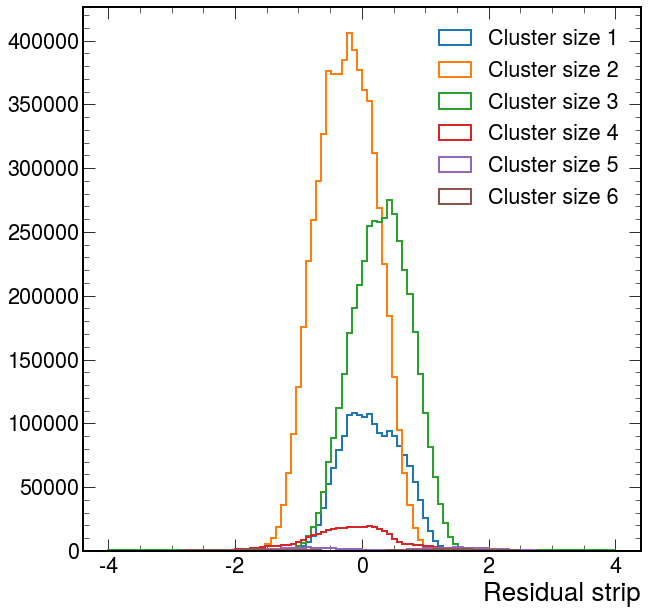

In [13]:
sigma_cls = dict()
sigma_cls_err = dict()

for cluster_size in range(1, 7):
    residuals = rechits_center - prophits_center_broad
    residual_filter = (rechits_center>100)&(rechits_center<350)
    residual_filter = (residual_filter)&(rechit_cluster_size==cluster_size)
    residuals = residuals[residual_filter]

    gauss = lambda x, A, mean, sigma: A*norm.pdf(x, mean, sigma)
    gauss2 = lambda x, A1, mean1, sigma1, A2, mean2, sigma2: gauss(x, A1, mean1, sigma1) + gauss(x, A2, mean2, sigma2)

    residuals_flat = ak.flatten(residuals)
    residuals_min_filter = ak.argmin(abs(residuals), axis=1, keepdims=True)
    residuals_flat = ak.flatten(residuals[residuals_min_filter])
    residuals_flat = residuals_flat[~ak.is_none(residuals_flat)]
    #print(residuals_flat)
    _ = residual_values, residual_edges, _ = plt.hist(
        residuals_flat,#-ak.mean(residuals_flat),
        bins=100, range=(-4, 4),
        histtype="step", linewidth=2, label=f"Cluster size {cluster_size}"
    )
    residual_bins = 0.5*(residual_edges[1:]+residual_edges[:-1])
    print("RMS", ak.std(residuals_flat[abs(residuals_flat)<5]))

    p0 = [1, 0, 1] + [0.1, 0, 10]
    popt, pcov = curve_fit(gauss2, residual_bins, residual_values, p0=p0)
    perr = np.sqrt(np.diag(pcov))
    #popt, pcov = curve_fit(gauss, residual_bins, residual_values, p0=p0)
    #print(popt)
    #print(perr)
    #A, mean, sigma = popt
    print(f"sigma1 = {popt[2]:1.2f} +- {perr[2]:1.2f}")
    print(f"sigma2 = {popt[5]:1.2f} +- {perr[5]:1.2f}")
    #print(f"mean = {popt[1]:1.2f}")
    
    sigma_cls[cluster_size] = min(popt[2], popt[5])
    sigma_cls_err[cluster_size] = min(perr[2], perr[5])
    #print(f"sigma {sigma_cls[cluster_size]} +- {sigma_cls_err[cluster_size]}")

    #x = np.linspace(residual_edges[0], residual_edges[-1], 100)
    #y = gauss2(x, *popt)
    #plt.plot(x, y, "-", color="red")
    plt.xlabel("Residual strip")
    plt.legend()

'texgyreheros-regular.otf' can not be subsetted into a Type 3 font. The entire font will be embedded in the output.


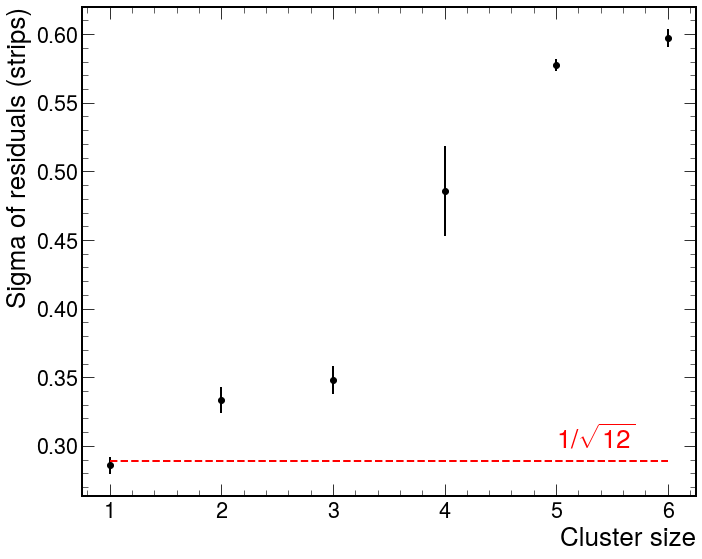

In [27]:
fig, ax = plt.subplots(figsize=(11,9))

ax.errorbar(
    sigma_cls.keys(), sigma_cls.values(),
    yerr = sigma_cls_err.values(), fmt="ok"
)
ax.plot(
    sigma_cls.keys(), [12**(-0.5)]*len(sigma_cls), "--", color="red"
)
ax.set_xlabel("Cluster size")
ax.set_ylabel("Sigma of residuals (strips)")
ax.text(
    5, 12**(-0.5)+0.01,
    "$1/\sqrt{12}$", color="red"
)

fig.savefig("/home/work/gem/testbeam/may2022/results/00000074/ge21/residuals_cls.pdf")

'texgyreheros-regular.otf' can not be subsetted into a Type 3 font. The entire font will be embedded in the output.


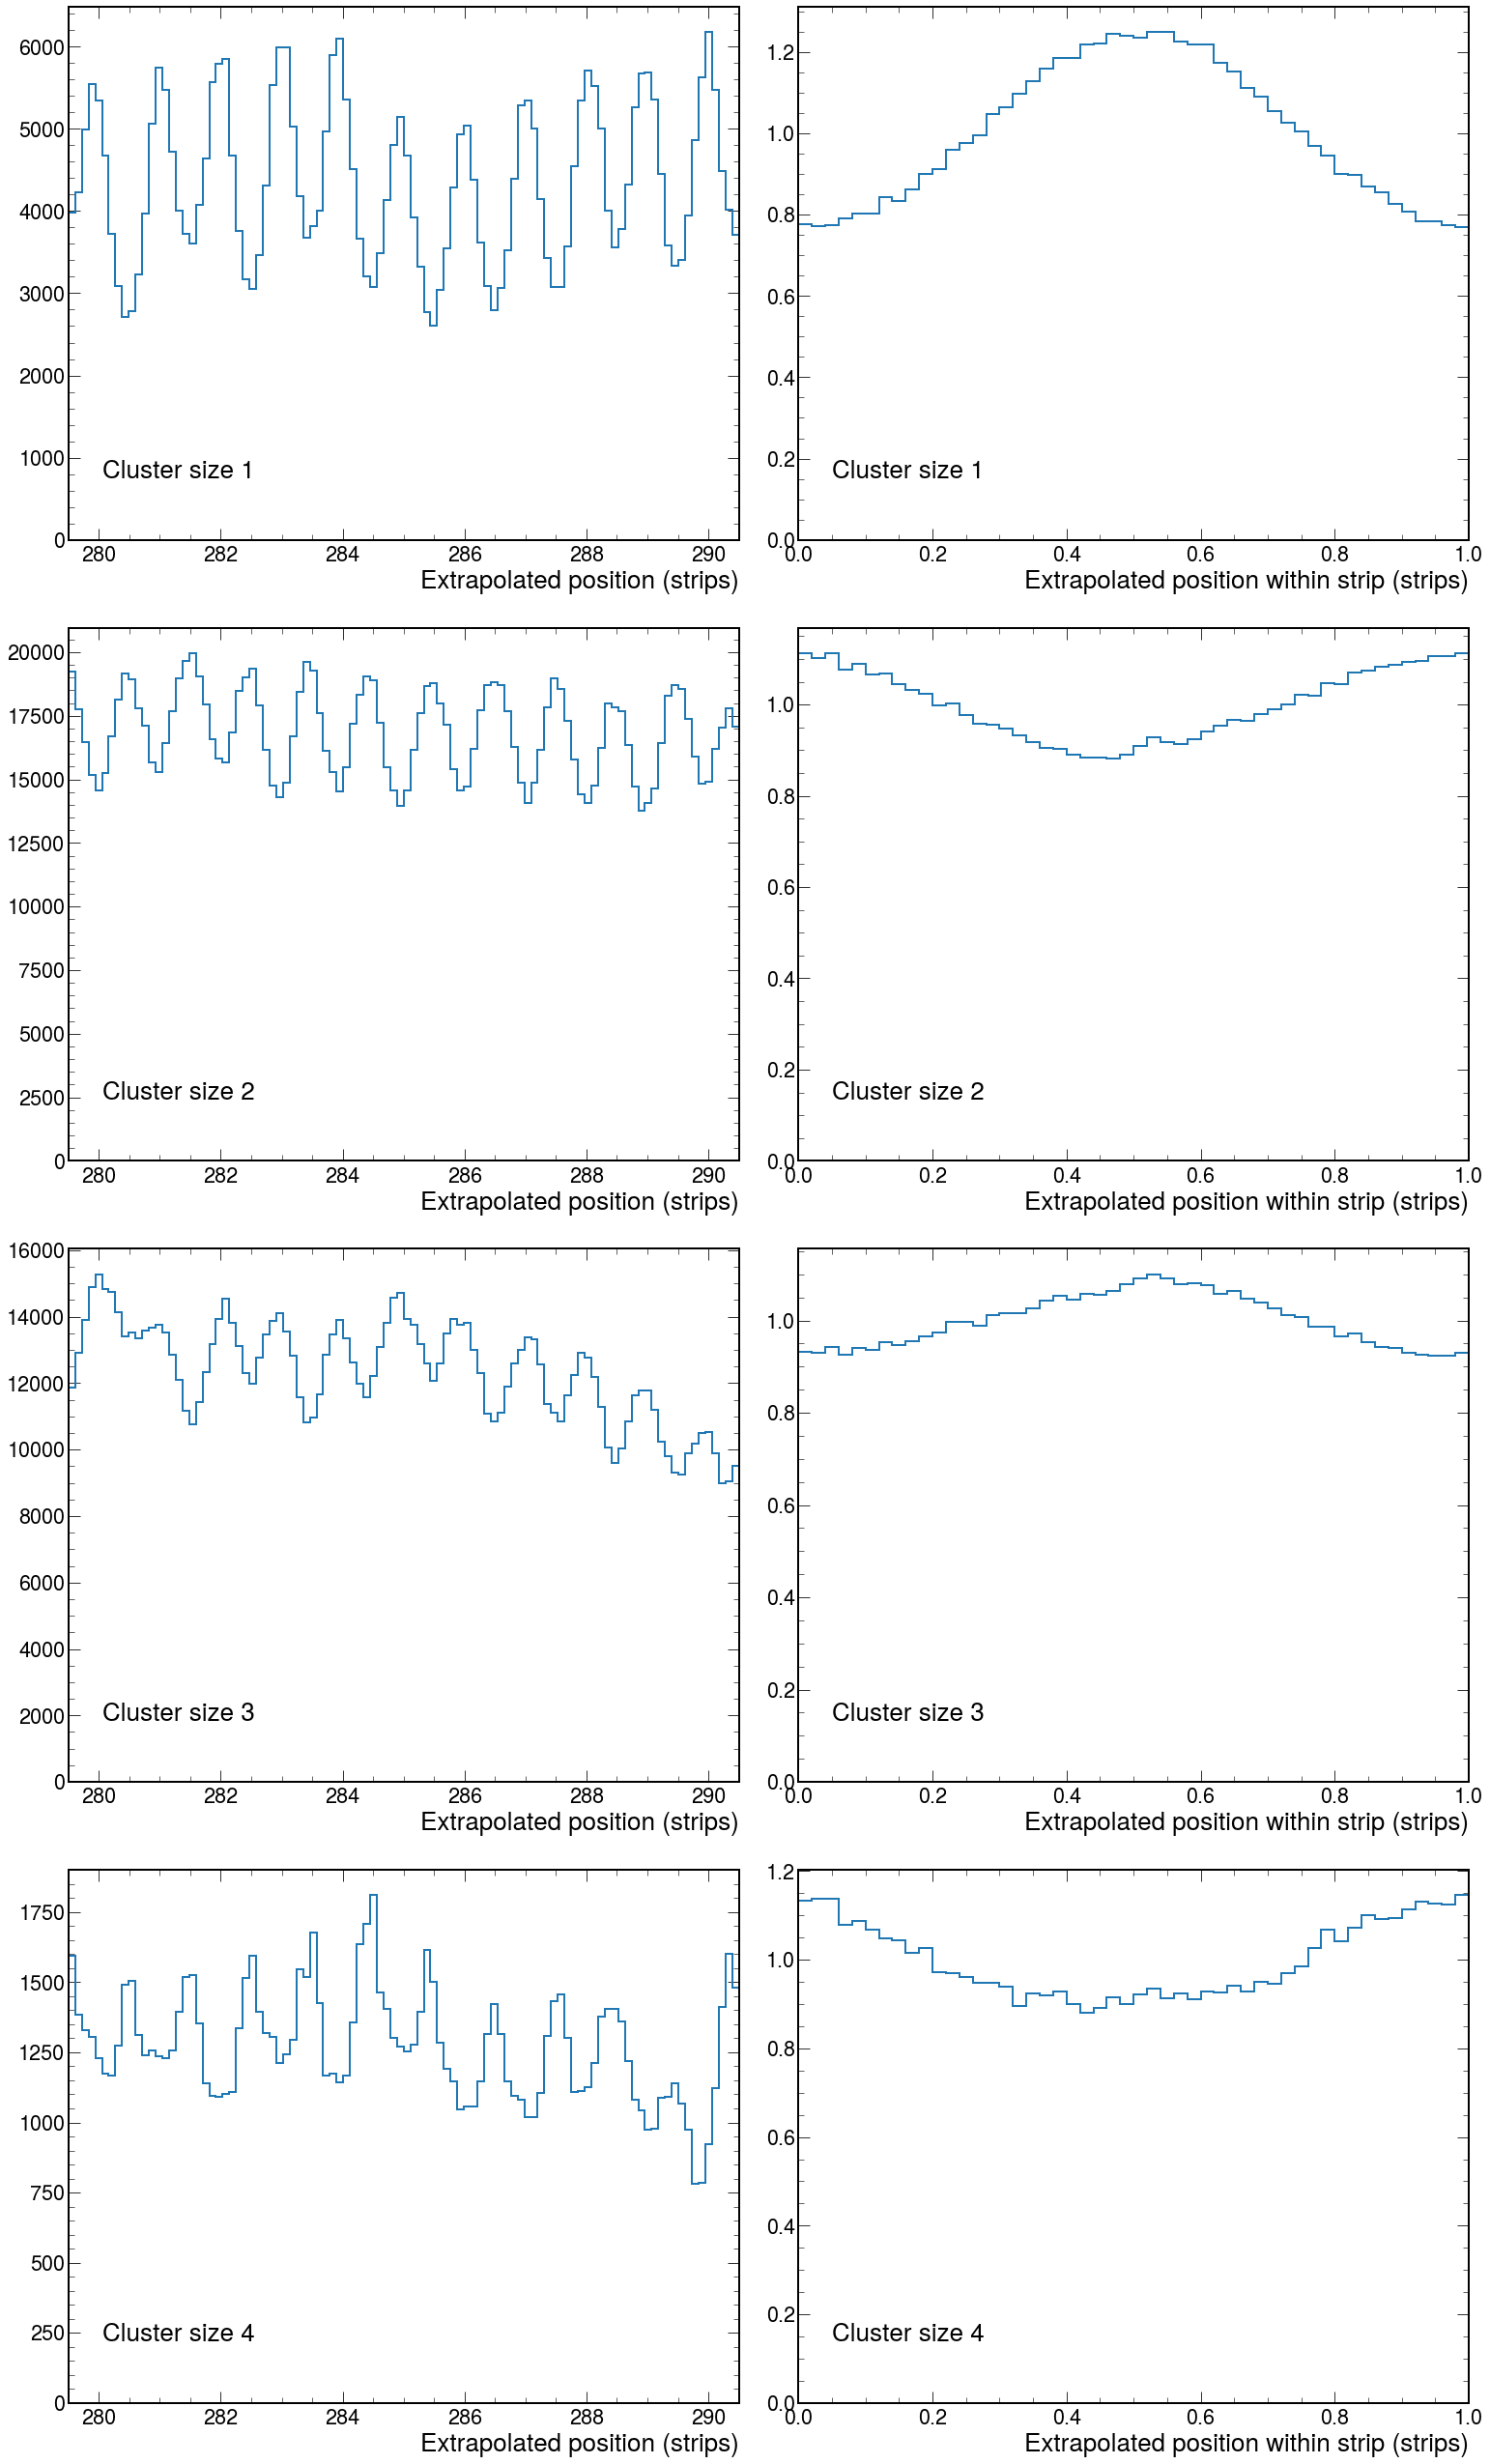

In [32]:
n_cluster_sizes = 4
fig, axs = plt.subplots(ncols=2, nrows=n_cluster_sizes, figsize=(22,9*n_cluster_sizes))

#prophits_center_aligned = prophits_center_broad - mean
horn_resolution = 10 # fraction of strips to plot
horn_range= (280-0.5, 290+0.5)
horn_bins = 10*horn_resolution

for i,cluster_size in enumerate(range(1, n_cluster_sizes+1)):
    
    prophits_cls = prophits_center_broad[rechit_cluster_size==cluster_size]
    
    residual_cls = rechits_center - prophits_center_broad
    residual_mean = ak.mean(ak.flatten(residual_cls))
    
    prophits_cls = prophits_cls[~ak.is_none(prophits_cls)]
    prophits_cls = prophits_cls - residual_mean
    _ = axs[i][0].hist(
        ak.flatten(prophits_cls), density=False,
        bins=horn_bins, range=horn_range,
        linewidth=2, histtype="step",
        label=f"Cluster size: {cluster_size}"
    )
    axs[i][0].text(
        0.05, 0.15,
        f"Cluster size {cluster_size}",
        transform = axs[i][0].transAxes,
        va="top", ha="left"
    )
    axs[i][0].set_xlim(horn_range[0], horn_range[1])
    axs[i][0].set_xlabel("Extrapolated position (strips)")

    prophits_within_strip = ak.flatten(prophits_cls[(prophits_cls>270)&(prophits_cls<300)]).to_numpy() + 0.5
    #prophits_within_strip -= prophits_within_strip.max()
    prophits_within_strip -= np.floor(prophits_within_strip)
    _ = axs[i][1].hist(
        prophits_within_strip, density=True,
        bins=50, #range=(0,1),
        linewidth=2, histtype="step",
        label=f"Cluster size {cluster_size}"
    )
    axs[i][1].set_xlim(0,1)
    axs[i][1].text(
        0.05, 0.15,
        f"Cluster size {cluster_size}",
        transform = axs[i][1].transAxes,
        va="top", ha="left"
    )
    axs[i][1].set_xlabel("Extrapolated position within strip (strips)")

#axs[i].legend()
fig.tight_layout()
fig.savefig("/home/work/gem/testbeam/may2022/results/00000074/ge21/horns.pdf")